In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing import sequence
from keras.models import Sequential, model_from_json
from keras.layers import Dense, Dropout
from keras import initializers
from sklearn.model_selection import train_test_split
from keras.layers.normalization import BatchNormalization
from keras import optimizers
from keras import initializers
import gc

Using TensorFlow backend.


In [2]:
# function for clearning train data!
# + remove IP
def clear_data(df, option):
    
    df['click_time'] = pd.to_datetime(df['click_time'])
    df['weekday'] = df['click_time'].dt.dayofweek
    df['hour'] = df['click_time'].dt.hour
    df = df.drop(columns=['ip','click_time'])
    if (option == 'train'):
        y = df['is_attributed']
        df = df.drop(columns=['is_attributed','attributed_time'], axis=1)
        return df, y
    elif (option == 'test'):
        sub_id = df['click_id']
        df = df.drop(columns=['click_id'], axis=1)
        return df, sub_id
    
    

In [3]:
print('load 10% training sample + train/val')
df = pd.read_csv('input_data/train_sampling5.csv')
df, y = clear_data(df,'train')
x_train, x_val, y_train, y_val = train_test_split(df,y,test_size=0.1)

x_train= x_train.drop(columns=['Unnamed: 0'])
x_val= x_val.drop(columns=['Unnamed: 0'])

print(x_train.head(2))
print(x_val.head(2))
print(y_train.head(2))
print(y_val.head(2))
del df, y; gc.collect()

load 10% training sample + train/val
         app  device  os  channel  weekday  hour
7343195   62       1  13       21        1     9
6861686   26       1  15      121        1     6
         app  device  os  channel  weekday  hour
8110613   26       1  13      121        3     8
6179706    2       1  13      219        2    20
7343195    1
6861686    0
Name: is_attributed, dtype: int64
8110613    0
6179706    0
Name: is_attributed, dtype: int64


89

In [4]:
print("define NN")
model = Sequential()
# give options of Dense, 
# https://github.com/keras-team/keras/blob/befbdaa076eedb2787ce340b1a5b4accf93d123d/examples/mnist_irnn.py
# RNN?? next try!
kernel_init=initializers.RandomNormal(mean=0.0, stddev=0.05, seed=None)

# structure of NN: 16 - 64
model.add(Dense(16,activation='relu',kernel_initializer=kernel_init,
                bias_initializer='zeros',input_shape=(x_train.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# added! 
model.add(Dense(32,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))


model.add(Dense(64,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(32,kernel_initializer=kernel_init,
                bias_initializer='zeros',activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(16,kernel_initializer=kernel_init,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(1,activation='sigmoid'))


define NN


In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                112       
_________________________________________________________________
batch_normalization_1 (Batch (None, 16)                64        
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                544       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
__________

In [6]:
gc.collect()
print("start training")
# control NN's option
# batch_size = 256
# epoch = 10
batch_size = 1024
epoch = 10

# class_weight = {0:0.1, 1:0.9}
class_weight = {0:0.5, 1:0.5}

exp_decay = lambda init, fin, steps: (init/fin)**(1/(steps-1)) - 1
steps = int(len(list(x_train)[0]) / batch_size) * epoch
lr_init, lr_fin = 0.0012, 0.0008 # lr=0.001 default 
lr_decay = exp_decay(lr_init, lr_fin, steps)
optimizer_adam = optimizers.Adam(lr=0.002, decay=lr_decay)

######################
# compile + training
model.compile(loss='binary_crossentropy',optimizer=optimizer_adam,metrics=['accuracy'])
model.fit(x_train,y_train,batch_size = batch_size,epochs=epoch,validation_data=(x_val,y_val),class_weight=class_weight)

del x_train, y_train; gc.collect()

start training
Train on 7758144 samples, validate on 862016 samples
Epoch 1/10
7758144/7758144 [==============================] - 188s 24us/step - loss: 0.1007 - acc: 0.9364 - val_loss: 0.1646 - val_acc: 0.9548
Epoch 2/10
7758144/7758144 [==============================] - 190s 25us/step - loss: 0.0888 - acc: 0.9450 - val_loss: 0.1719 - val_acc: 0.9540
Epoch 3/10
7758144/7758144 [==============================] - 194s 25us/step - loss: 0.0869 - acc: 0.9465 - val_loss: 0.1702 - val_acc: 0.9515
Epoch 4/10
7758144/7758144 [==============================] - 195s 25us/step - loss: 0.0863 - acc: 0.9470 - val_loss: 0.1681 - val_acc: 0.9516
Epoch 5/10
7758144/7758144 [==============================] - 195s 25us/step - loss: 0.0861 - acc: 0.9472 - val_loss: 0.1733 - val_acc: 0.9530
Epoch 6/10
7758144/7758144 [==============================] - 196s 25us/step - loss: 0.0859 - acc: 0.9474 - val_loss: 0.1675 - val_acc: 0.9517
Epoch 7/10
7758144/7758144 [==============================] - 197s 25us/st

60

[[ 0.03639374]
 [ 0.0211255 ]
 [ 0.0250712 ]
 ..., 
 [ 0.02132771]
 [ 0.02651656]
 [ 0.02126233]]
((862016, 1), (862016,))
         app  device  os  channel  weekday  hour
8110613   26       1  13      121        3     8
6179706    2       1  13      219        2    20
900159    14       1  13      134        3     4
4734133    3       1   9      115        2     8
4044973    9       1  13      334        1    22


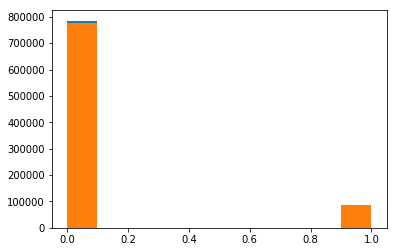

In [7]:
kk = model.predict(x_val,batch_size=batch_size,verbose=2)
print(kk)

print(kk.shape,y_val.shape)
plt.hist(np.round(kk))
plt.hist(y_val)
print(x_val.head())


In [8]:
print("Saved model to disk")
json_string = model.to_json()
with open("saved_models/model3.json", "w") as json_file:
    json_file.write(json_string)
model.save_weights('saved_models/weights3.h5')

Saved model to disk


In [9]:
# print("predicting_test_sample")
# dff = pd.read_csv('input_data/test_sampling5.csv','train')
# print(dff.head())
# dff, yy = clear_data(dff,'train')

# output = model.predict(dff,batch_size=batch_size,verbose=2)

# dd = np.array([output.values,yy.values])
# plt.hist(dd,np.arange(-0.05,1,0.1),normed=True)


In [10]:
print("predicting")
df_sub = pd.DataFrame()
ttest = pd.read_csv('input_data/kaggle_test.csv')
print("finish read test data")

ttest, idd = clear_data(ttest,'test')
df_sub['click_id'] = idd.astype('int32')
df_sub['is_attributed'] = model.predict(ttest,batch_size=batch_size,verbose=2)



predicting
finish read test data


check result
           click_id  is_attributed
count  1.879047e+07   1.879047e+07
mean   9.395234e+06   6.878012e-02
std    5.424341e+06   1.488837e-01
min    0.000000e+00   2.039872e-02
25%    4.697617e+06   2.118955e-02
50%    9.395234e+06   2.138998e-02
75%    1.409285e+07   2.725724e-02
max    1.879047e+07   8.969088e-01


(array([ 16622236.,    480325.,    643527.,    181429.,    139436.,
           109337.,     51593.,    100198.,    248727.,    213661.]),
 array([ 0.02039872,  0.10804972,  0.19570073,  0.28335173,  0.37100273,
         0.45865374,  0.54630474,  0.63395575,  0.72160675,  0.80925776,
         0.89690876]),
 <a list of 10 Patch objects>)

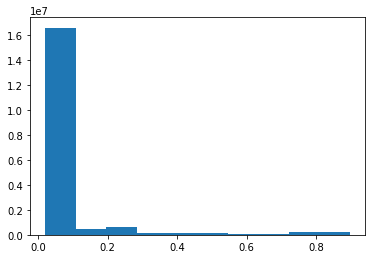

In [11]:
print("check result")
print(df_sub.describe())
plt.hist(df_sub['is_attributed'])

In [ ]:
print("save the result")
df_sub.to_csv('sub_result/result_code3_sample5.csv',index=False)




save the result


In [ ]:
plt.hist(np.round(df_sub['is_attributed']))